# Roll decay test parameter sensitivity many


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
import copy
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [112]:
exclude_files = ['20084871055k.06.asc',
                ]
acii_directory_path = os.path.join(rolldecay.data_path,'project1','Ascii files')
file_names = []
for file_name in os.listdir(acii_directory_path):
    file_names.append(file_name)
    
file_names = list(set(file_names) - set(exclude_files))


In [113]:
def fit(pipeline):
    
    pipelines = {}
    
    for file_name in file_names:
        
        ascii_file_path = os.path.join(acii_directory_path,file_name)
        df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
        
        # Exclude tests where roll is not big enough:
        if ((df_raw['phi'].max() < np.deg2rad(1)) |
            (df_raw['phi'].min() > -np.deg2rad(1))):
            continue
        
        
        pipeline = copy.deepcopy(pipeline)
        pipeline.fit(X=df_raw)
        pipelines[file_name] = pipeline
        
    return pipelines

In [114]:
def predict(pipelines):
    
    df = pd.DataFrame()
    
    for file_name, pipeline in pipelines.items():
        
        estimator = pipeline[-1]
        s = pd.Series(estimator.parameters, name=file_name)
        s['score'] = estimator.score(X=estimator.X)
        s['mean_damping'] = estimator.calculate_average_linear_damping(phi_a=np.deg2rad(4))
        df = df.append(s)
        
    return df

## Direct

In [115]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.2))
offset_transformer = OffsetTransformer()
direct_estimator = DirectEstimator()

steps = [
('filter',lowpass_filter),
('scaler',scaler),
('cutter', cutter), 
('offset_transformer',offset_transformer),
('direct_estimator', direct_estimator)]
    
pipeline_direct = Pipeline(steps) # define the pipeline object.

In [116]:
pipeline_directs = fit(pipeline=pipeline_direct)

In [117]:
pipeline = pipeline_directs['20084871051k.01.asc']

In [118]:
df_direct = predict(pipelines=pipeline_directs)

## Norwegian

In [119]:
norwegian_estimator = NorwegianEstimator()

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', norwegian_estimator)]
        
pipeline_norwegian = Pipeline(steps) # define the pipeline object.   

In [120]:
pipeline_norwegians = fit(pipeline=pipeline_norwegian)

In [121]:
df_norwegian = predict(pipelines=pipeline_norwegians)

## Linear method

In [122]:
direct_linear_estimator = DirectLinearEstimator()

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', direct_linear_estimator)]
        
pipeline_direct_linear = Pipeline(steps) # define the pipeline object.   

In [123]:
pipeline_direct_linears = fit(pipeline=pipeline_direct_linear)

In [124]:
df_direct_linear = predict(pipelines=pipeline_direct_linears)
df_direct_linear['d']=0

In [125]:
mask = df_direct['score'] > 0.90
df_direct_good = df_direct.loc[mask].copy()
df_direct_linear_good = df_direct_linear.loc[mask].copy()
df_norwegian_good = df_norwegian.loc[mask].copy()



In [126]:
df1 = df_direct_good.sort_values(by='score', ascending=False).iloc[-10:]
index = df1.index.copy()
df1.reset_index(inplace=True)

df1['method'] = 'direct'
df2 = df_direct_linear_good.loc[index].reset_index()
df2['method'] = 'direct linear'
df3 = df_norwegian_good.loc[index].reset_index()
df3['method'] = 'norwegian'


df_comparison = pd.concat([df1,df2,df3], sort=False)

In [127]:
df_comparison.isnull().any()

index           False
d               False
mean_damping    False
omega0          False
score           False
zeta            False
method          False
dtype: bool

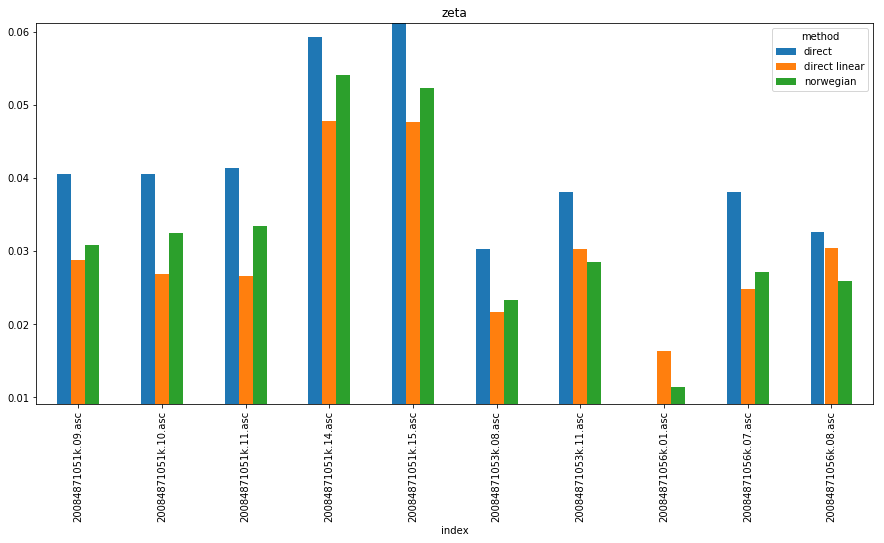

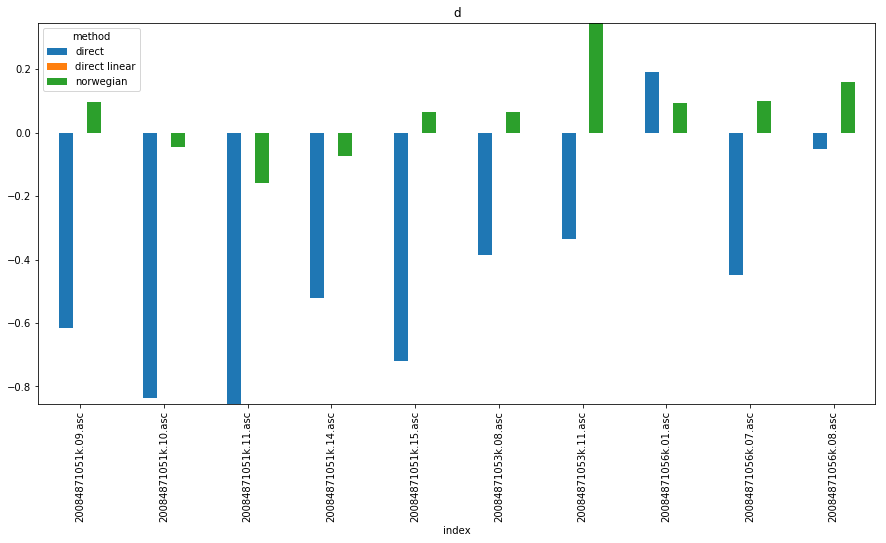

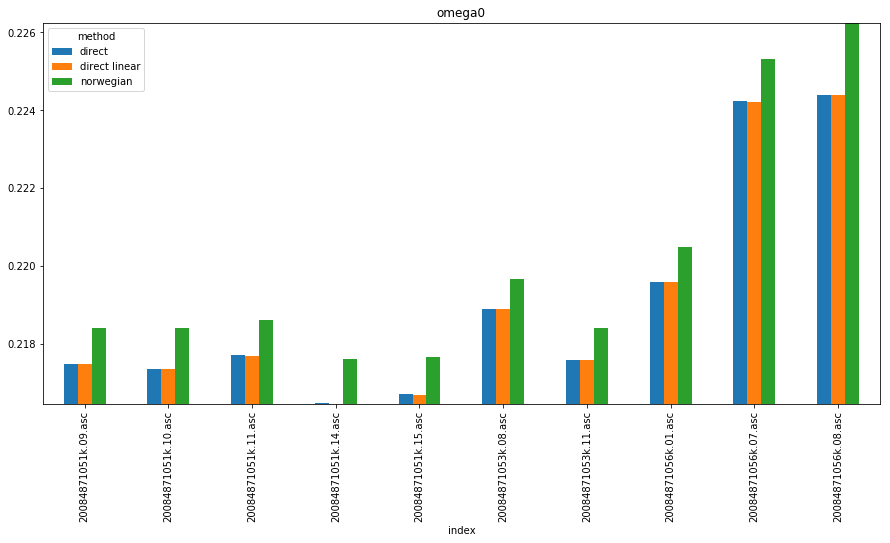

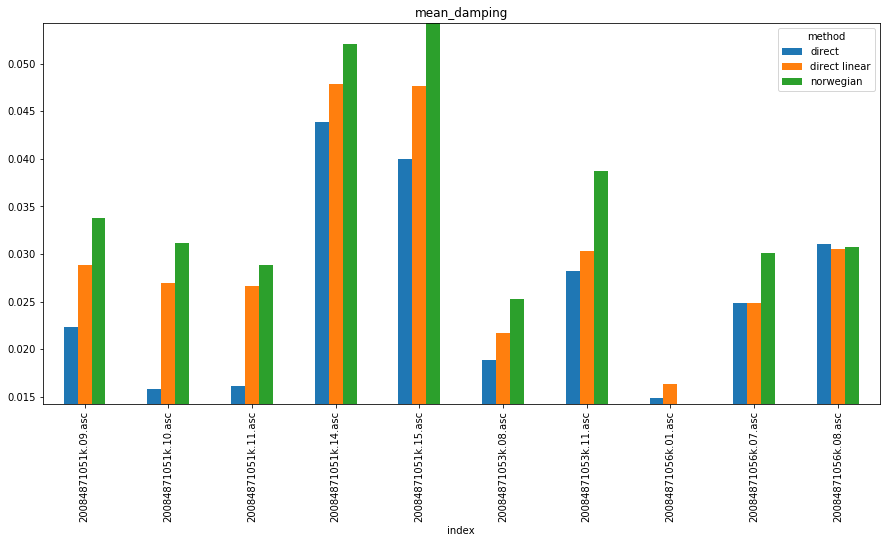

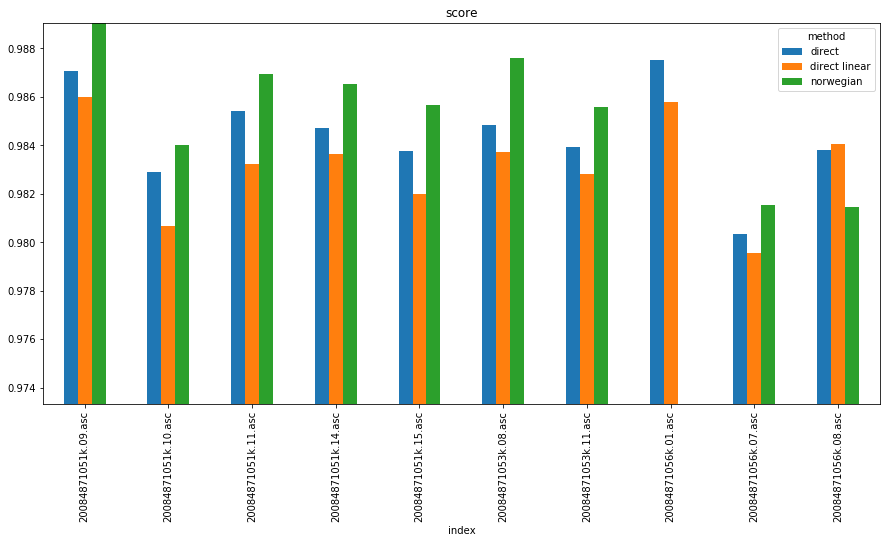

In [128]:
for column in ['zeta','d','omega0','mean_damping','score']:
    fig,ax = plt.subplots()
    
    df = df_comparison.pivot(index='method',columns='index', values=column).transpose()
    df.plot(kind='bar', ax=ax)
    ylim = ax.get_ylim()
    ax.set_ylim(df.min().min(),df.max().max())
    ax.set_title(column)


In [129]:
file = df_direct_good.iloc[0].name
file

'20084871055k.12.asc'

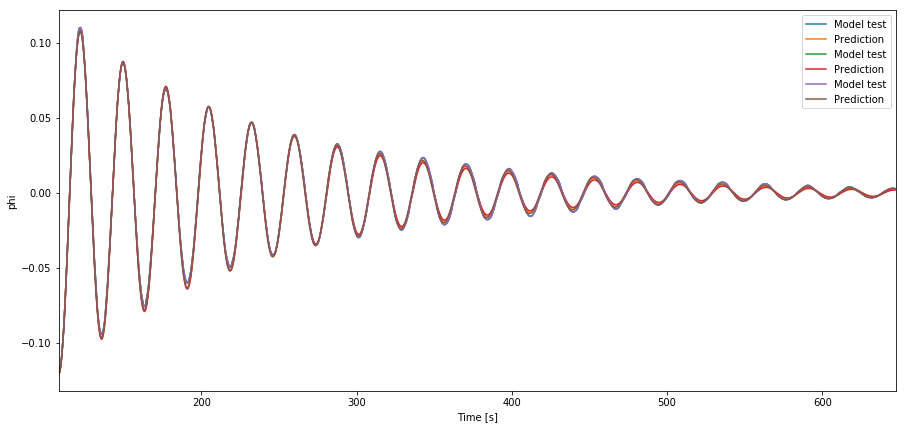

In [130]:
file = df_direct_good.iloc[0].name
#file = '20084871056k.14.asc'


pipelines = [pipeline_directs, pipeline_direct_linears, pipeline_norwegians]

fig,ax = plt.subplots()
for p in pipelines:

    pipeline = p[file]
    estimator = pipeline[-1]
    estimator.plot_fit(ax=ax)


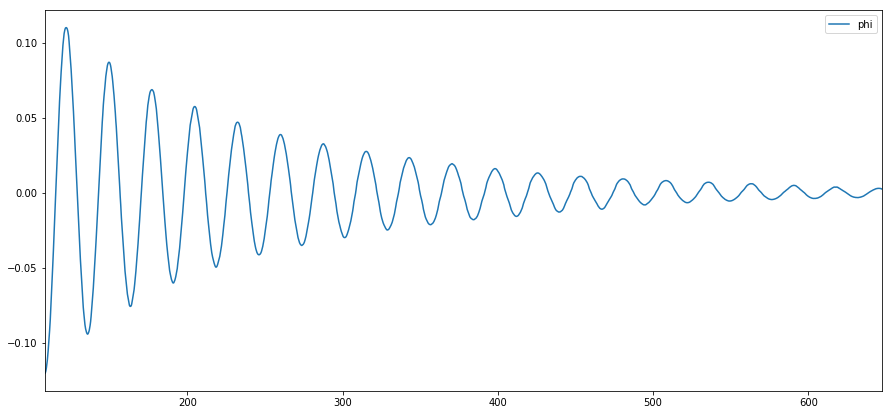

In [131]:
estimator.X.plot(y='phi')

In [132]:
df_direct_good.describe()

,d,mean_damping,omega0,score,zeta
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,-0.057996,0.022891,0.219964,0.994272,0.024609
std,0.277327,0.010383,0.003990,0.005074,0.013491
min,-1.156637,0.005327,0.214754,0.980355,0.000199
25%,-0.148155,0.015539,0.217453,0.992041,0.012644
50%,0.010931,0.020129,0.219111,0.996100,0.023122
75%,0.149420,0.031302,0.220677,0.998328,0.035164
max,0.328883,0.049744,0.231108,0.999493,0.061257


In [133]:
df_norwegian_good.describe()

,d,mean_damping,omega0,score,zeta
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,0.143687,0.025124,0.220337,0.992540,0.020867
std,0.134849,0.011132,0.004080,0.007317,0.012192
min,-0.171367,0.006027,0.214791,0.968802,0.003060
25%,0.066402,0.015611,0.217878,0.989225,0.010255
50%,0.149692,0.023682,0.219375,0.994676,0.020060
75%,0.218487,0.033386,0.220810,0.997943,0.029058
max,0.650619,0.054258,0.231827,0.999559,0.054156


## The linear model is performing as good as the two quadratic for the present data
Need to investigate more ships to see if this changes...

In [134]:
df_direct_linear_good.describe()

,mean_damping,omega0,score,zeta,d
count,71.000000,71.000000,71.000000,71.000000,71.0
mean,0.024043,0.219960,0.993043,0.024043,0.0
std,0.010702,0.003991,0.005539,0.010702,0.0
min,0.005273,0.214753,0.979571,0.005273,0.0
25%,0.016095,0.217447,0.989176,0.016095,0.0
50%,0.021887,0.219111,0.993876,0.021887,0.0
75%,0.031277,0.220668,0.998129,0.031277,0.0
max,0.050487,0.231107,0.999561,0.050487,0.0
